# Implementing Image Classification through Fourier Neural Operator


## Backend : Tensorflow / Keras
## Datasets : Tensorflow.keras.datasets MNIST

### GPU : NVIDIA A100-PCIE-40GB x 2

In this notebook we will introduce the brief theory behind the Fourier Neural Operators and use them to solve a data-driven image classification problem. The theory is adopted from the [paper](https://arxiv.org/pdf/2010.08895.pdf) by Zongyi Li et al. 


- Author of the Notebook : $Kozak Hou$
- Email : kozak20010716@g.ncu.edu.tw
- Tel : +886-905804898

---
## Import Necessary Libraries


In [1]:
#Clear unnecessary memory
from tensorflow.keras import backend as K
import tensorflow as tf
K.clear_session()
import warnings
warnings.filterwarnings('ignore')

# Enable previous version's API to apply in this examples
from __future__ import absolute_import, division, print_function, unicode_literals

# Preparing Datasets
from tensorflow.keras.datasets import mnist

# Import Necessary Libraries : TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.signal import fft, fft2d, ifft, ifft2d, rfft, irfft, rfft2d, irfft2d
import scipy.misc
from matplotlib.pyplot import imshow
from tensorflow import Tensor

# Only used in Jupyter notebook
%matplotlib inline 


# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential #The base for NN

from tensorflow.keras.layers import Dense  #Layers of NN
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical #Taking tags to encode through One-Hot encoding. e.g. 4-> 0000100000
import matplotlib.pyplot as plt
import numpy as np



print(tf.__version__)


# Loading Datasets
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()


print("There're 60000 28x28 pixels training data and 60000 training tags")

2.10.1
There're 60000 28x28 pixels training data and 60000 training tags


---
## Data Preprocessing

In [2]:
#Normalized
train_images = train_images/255.0
test_images =  test_images/255.0

#As each images is 28 x 28, and we will later apply CNN; 
#therefore, we have to reshape the images from 2-D to 4-D
w, h = 28, 28
train_images = train_images.reshape(train_images.shape[0], w, h, 1)
test_images = test_images.reshape(test_images.shape[0], w, h, 1)

In [3]:
train_images.shape

(60000, 28, 28, 1)

---
##  Comfirming the GPU configuration



The tensorflow APIs about testing whether the GPU is functioning are as follow :

- **The Python Code**

```python
  import tensorflow as tf
  if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

  else:
    print("Please install GPU version of TF")
```


- **output** 

 Default GPU Device:/device:GPU:0

In [4]:
import tensorflow as tf
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


2022-12-22 16:04:22.590298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /device:GPU:0 with 38139 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2022-12-22 16:04:22.592370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /device:GPU:1 with 38139 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0001:01:00.0, compute capability: 8.0
2022-12-22 16:04:22.608308: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /device:GPU:0 with 38139 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2022-12-22 16:04:22.610000: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /device:GPU:1 with 38139 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0001:01:00.0, compute capability: 8.0


---
## List all categories
- In this example, we have, obviously, 10 numbers from 0 to 9

In [5]:
classess = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

---
# Applying Fourier Neural Operator

## FNO Theory

Fourier neural operator (FNO) is a data-driven architecture which can be used to parameterize solutions for a distribution of PDE solutions. The key feature of FNO is the spectral convolutions: operations that place the integral kernel in Fourier space. The spectral convolution (Fourier integral oprator) is defined as follows:

\begin{equation}
(\mathcal{K}(\mathbf{w})\phi)(x) = \mathcal{F}^{-1}(R_{\mathbf{W}}\cdot \left(\mathcal{F}\right)\phi)(x), \quad \forall x \in D
\end{equation}

where $\mathcal{F}$ and $\mathcal{F}^{-1}$ are the forward and inverse Fourier transforms, respectively.
$R_{\mathbf{w}}$ is the transformation which contains the learnable parameters $\mathbf{w}$. Note this operator is calculated
over the entire *structured Euclidean* domain $D$ discretized with $n$ points.

Fast Fourier Transform (FFT) is used to perform the Fourier transforms efficiently and the resulting transformation $R_{\mathbf{w}}$ is just finite size matrix of learnable weights. In side the spectral convolution, the Fourier coefficients are truncated to only the lower modes which intern allows explicit control over the dimensionality of the spectral space and linear operator.

The FNO model is a the composition of a fully-connected "lifting" layer, $L$ spectral convolutions with point-wise linear skip connections and a decoding point-wise fully-connected neural network at the end.

\begin{equation}
u_{net}(\Phi;\theta) = \mathcal{Q}\circ \sigma(W_{L} + \mathcal{K}_{L}) \circ ... \circ \sigma(W_{1} + \mathcal{K}_{1})\circ \mathcal{P}(\Phi), \quad \Phi=\left\{\phi(x); \forall x \in D\right\}
\end{equation}

in which $\sigma(W_{i} + \mathcal{K}_{i})$ is the spectral convolution layer $i$ with the point-wise linear transform $W_{i}$ and activation function $\sigma(\cdot)$. $\mathcal{P}$ is the point-wise lifting network that projects the input into a higher-dimensional latent space, $\mathcal{P}: \mathbb{R}^{d_in} \rightarrow \mathbb{R}^{k}$.

Similarly $\mathcal{Q}$ is the point-wise fully-connected decoding network, $\mathcal{P}: \mathbb{R}^{k} \rightarrow \mathbb{R}^{d_out}$. Since all fully-connected components of FNO are point-wise operations, the model is invariant to the dimensionality of the input.


**Note:** While FNO is technically invariant to the dimensionality of the discretized domain $D$, this domain *must* be a structured grid in Euclidean space. The inputs to FNO are analgous to images, but the model is invariant to the image resolution.

---
## Fourier Neural Operator (FNO) Control Flow

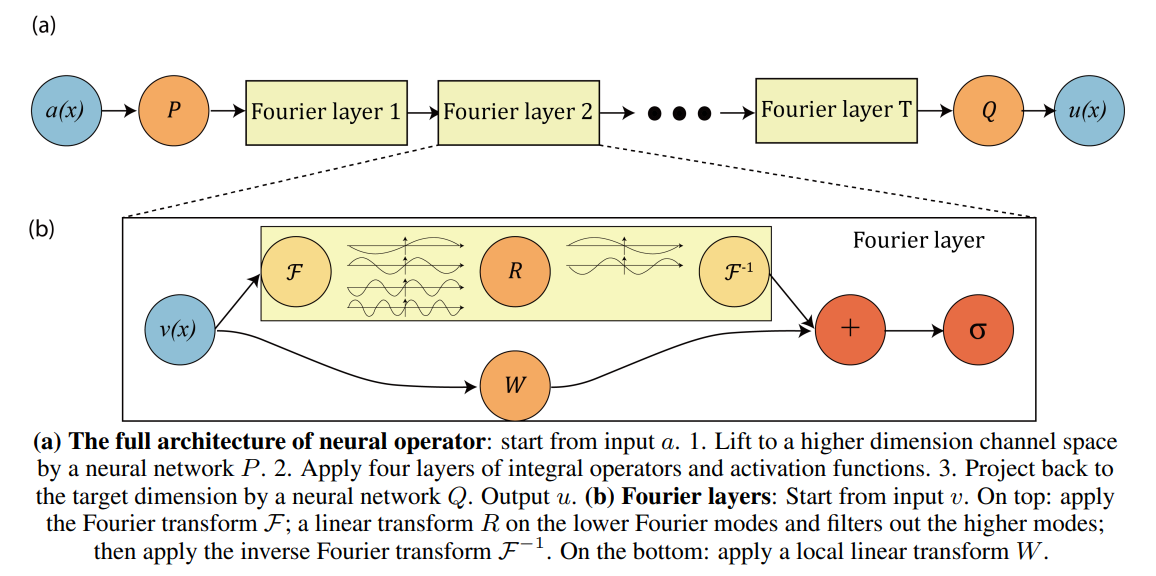

---

***First Part***

The first step we should implement is raising the dimension throuh 1 x 1 kernel's convolution, which often bein regarded as encoder layer. 

$$a(x) \rightarrow P $$

---------------

***Middle Part***

As we get the higher dimensional input space, we will start to build our Fourier Neural Operator.

This method divided the input into two parts. One has to entry in the fourier space through fast fourier transfrom, and the other one is same as usual, the later one will be taken as residual to supplement the signal which been eradicate by linear transfrom within FFT. 

After finish the steps mentioned above. We will, as usual, add together and connect with an activation function, which used to be ReLU (Rectified Linear Units)

We repeat the steps for four time and then output our result to the final parts.

--------

***Final Part***

After we obtain the output from FNO, we have to decoded our latent output through decoder layers, which is the same as encoder, we use 1 x 1 kernel's convolution to lower our dimensional space. Then output our final results. 

$$Q  \rightarrow u(x) $$

In [6]:
# First Part : Defining a(x) --> P

def P(X, F1, k_size, s, stage):
    
    # Name definition
    P_Name = 'P-layer' + str(stage)
    P_BN_Name = 'P-layer-BN' + str(stage)
    
    X = Conv2D(filters = F1, kernel_size = (k_size, k_size), strides = (s, s), padding = 'valid',
              name = P_Name, kernel_initializer = glorot_uniform(seed = 0))(X)
    
    X = BatchNormalization(axis = 3, name = P_BN_Name)(X)
    
    X = Activation('relu')(X)
    
    return X

In [7]:
# Middle Part : Defining FFT and Residual block

def FourierLayer(X, stage):
    
    # Name definition
    FFT_name = 'fft-layer' + str(stage)
    RFFT_name = 'ifft-layer' + str(stage)
    
    
    Res_X = X
    
    
    X = rfft2d(X, name = FFT_name)
    
    
    out_ft = tf.zeros((1, X.shape[1], X.shape[2], X.shape[3]),dtype=tf.dtypes.complex64)

    
    out_ft_first = tf.Variable(np.array(out_ft.shape))
    out_ft_first = tf.math.multiply(X[:, :, :4, :4], tf.cast(Res_X[:, :, :4, :4], tf.complex64))

    out_ft_end  = tf.Variable(np.array(out_ft.shape))
    out_ft_end = tf.math.multiply(X[:, :, -4:, :4], tf.cast(Res_X[:, :, -4:, :4], tf.complex64))


    o1 = tf.concat([out_ft_first,out_ft[:,:,:4,4:]],axis=3)
    o2 = tf.concat([out_ft[:,:,-4:,4:],out_ft_end],axis=3)
    
    out_ft = tf.concat([o1,o2],axis=2)

    
    X = irfft2d(X,name = RFFT_name)
    
    
    X = Add()([X, Res_X])
    
    X = Activation('relu')(X)

    
    return X



In [8]:
# Final Part : Defining Q --> u(x)

def Q(X, F1, k_size, s, stage):
    
    # Name definition
    Q_Name = 'Q-layer' + str(stage)
    Q_BN_Name = 'Q-layer-BN' + str(stage)
    
    
    X = Conv2D(filters = F1, kernel_size = (k_size, k_size), strides = (s, s), padding = 'same',
              name = Q_Name, kernel_initializer = glorot_uniform(seed = 0))(X)
    
    X = BatchNormalization(axis = 3, name = Q_BN_Name)(X)
    
    X = Activation('relu')(X)
    
    return X

---
## There seems to have some memory allocated problem in different Tensorflow's version, we use the following method to fix it.

```python
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
```

In [9]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

---
# Building the Model of Fourier Neural Operator (FNO)

In [10]:
def FNO(input_shape = (w, h, 1), classes = classess):
    
    X_input = Input(shape = input_shape)
    
    # Zero-Padding
    X = ZeroPadding2D((2, 2))(X_input)
    
    # First Part
    X = P(X, F1 = 64, k_size = 1, s = 1, stage = 1)
#    X = P(X, F1 = 256, k_size = 2, s = 2, stage = 2)
#    X = P(X, F1 = 256, k_size = 2, s = 2, stage = 3)
    X = MaxPooling2D((2, 2), strides = (2, 2))(X)
    X = tf.keras.layers.Dropout(0.3)(X)
    
    
    # Middle Part
    X = FourierLayer(X, stage = 1)
    X = FourierLayer(X, stage = 2)
    X = FourierLayer(X, stage = 3)
    X = FourierLayer(X, stage = 4)
    
    # Final Part

    X = Q(X, F1 = 64, k_size = 1, s = 1, stage = 1)
#    X = Q(X, F1 = 1024, k_size = 1, s = 2, stage = 2)
#    X = Q(X, F1 = 256, k_size = 1, s = 2, stage = 3)
#    X = UpSampling2D((2, 2))(X)
#    X = tf.keras.layers.Dropout(0.4)(X)
    X = Flatten()(X)
    X = Dense(784, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dense(len(classess), activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs = X_input, outputs = X, name = 'Fourier-Neural-Operator')
    
    return model

---
## Clearing the unnecessary memory again 

In [11]:
# #Clear unnecessary memory
# from tensorflow.keras import backend as K
# import tensorflow as tf
# K.clear_session()

---
## Training and Fitting

Instructions for updating:
Colocations handled automatically by placer.


2022-12-22 16:04:23.126263: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38139 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2022-12-22 16:04:23.127968: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38139 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0001:01:00.0, compute capability: 8.0
2022-12-22 16:04:23.135836: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Model: "Fourier-Neural-Operator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 32, 32, 1)   0           ['input_1[0][0]']                
                                                                                                  
 P-layer1 (Conv2D)              (None, 32, 32, 64)   128         ['zero_padding2d[0][0]']         
                                                                                                  
 P-layer-BN1 (BatchNormalizatio  (None, 32, 32, 64)  256         ['P-layer1[0][0]']               
 n)                                                                         

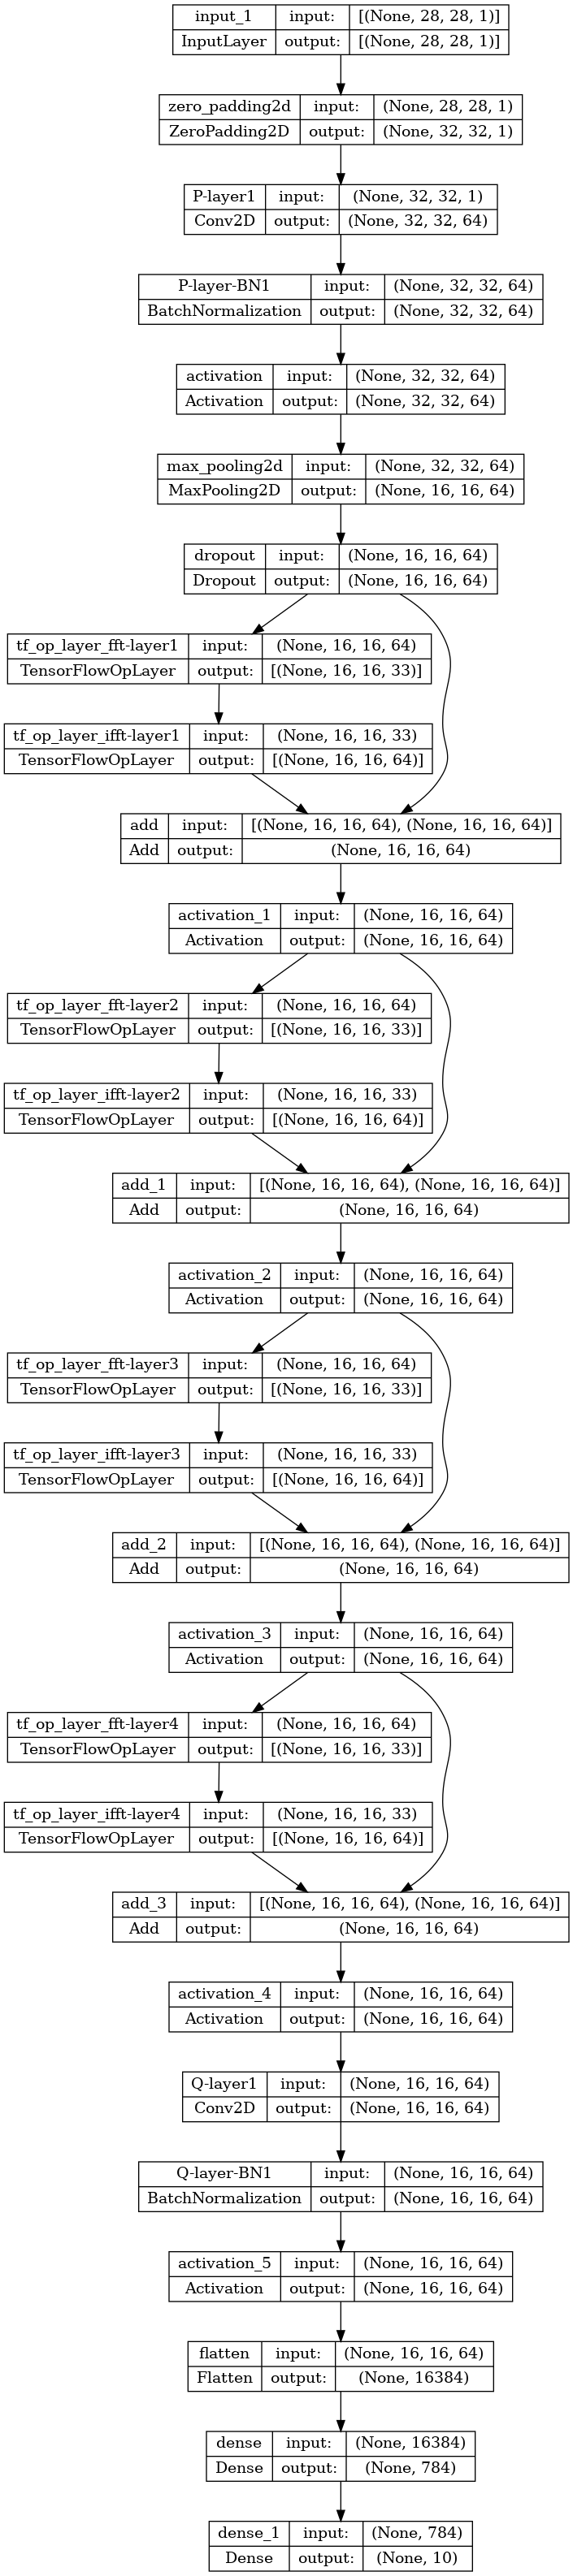

In [12]:
model = FNO(input_shape = (w, h, 1), classes = classess)

# Take a look at the model summary
model.summary()
plot_model(model, to_file = 'FNO_Model_CF.png', show_shapes = True, show_layer_names = True)

In [13]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'MeanSquaredError'])

In [ ]:
from time import time

original_time = time()
history = model.fit(train_images, 
                    train_labels,
                    batch_size=2048,
                    epochs=30,
                    validation_split = 0.1)


print("\n\n\nCalculating time : ", time()-original_time)
print(history.history.keys())

Train on 54000 samples, validate on 6000 samples
Epoch 1/30


2022-12-22 16:04:26.119138: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


 2048/54000 [>.............................] - ETA: 28s - loss: 2.6081 - accuracy: 0.1357 - MeanSquaredError: 26.5025

2022-12-22 16:04:26.574228: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


54000/54000 [==============================] - 5s 84us/sample - loss: 1.8394 - accuracy: 0.6217 - MeanSquaredError: 27.3159 - val_loss: 0.9332 - val_accuracy: 0.8210 - val_MeanSquaredError: 27.4795
Epoch 2/30
54000/54000 [==============================] - 3s 61us/sample - loss: 0.4416 - accuracy: 0.8820 - MeanSquaredError: 27.3447 - val_loss: 1.2120 - val_accuracy: 0.6173 - val_MeanSquaredError: 27.4812
Epoch 3/30
54000/54000 [==============================] - 3s 61us/sample - loss: 0.3171 - accuracy: 0.9127 - MeanSquaredError: 27.3545 - val_loss: 1.3052 - val_accuracy: 0.5838 - val_MeanSquaredError: 27.4810
Epoch 4/30
54000/54000 [==============================] - 3s 60us/sample - loss: 0.2649 - accuracy: 0.9269 - MeanSquaredError: 27.3581 - val_loss: 1.3407 - val_accuracy: 0.5695 - val_MeanSquaredError: 27.4831
Epoch 5/30
54000/54000 [==============================] - 3s 61us/sample - loss: 0.2324 - accuracy: 0.9367 - MeanSquaredError: 27.3601 - val_loss: 1.4267 - val_accuracy: 0.502

---
# Evaluate the Training Process (Loss and Accuracy)

In [ ]:
# Loss
plt.figure(figsize = (9, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('FNO model loss', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.xlabel('epoch', fontsize = 15)
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
# Accuracy
plt.figure(figsize = (9, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('FNO model train accuracy', fontsize = 15)
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('accuracy', fontsize = 15)
plt.legend(['train accuracy', 'test accuracy'], loc = 'upper right')
plt.show()

---
# Evaluate the Testing Process (Loss and Accuracy)

In [ ]:
# Evaluating the model using the test set
loss, accuracy, MSE = model.evaluate(test_images, test_labels, verbose = 1)
print('\nTest accuracy:', accuracy)

---
# Making Prediction from the test_images

In [ ]:
predictions = model.predict(test_images)

---
# Defining the Visualizing Function

In [ ]:
# Reshape input data from (IMG_SIZE, IMG_SIZE) to (IMG_SIZE, IMG_SIZE, 1)
train_images = train_images.reshape(train_images.shape[0], w, h)
test_images = test_images.reshape(test_images.shape[0], w, h)


# Helper functions to plot images 
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classess[predicted_label],
                                100*np.max(predictions_array),
                                classess[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

---
# Data Visualization

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

---
# References : 


**Citations**

```
@misc{li2020fourier,
      title={Fourier Neural Operator for Parametric Partial Differential Equations}, 
      author={Zongyi Li and Nikola Kovachki and Kamyar Azizzadenesheli and Burigede Liu and Kaushik Bhattacharya and Andrew Stuart and Anima Anandkumar},
      year={2020},
      eprint={2010.08895},
      archivePrefix={arXiv},
      primaryClass={cs.LG}
}

@misc{li2020neural,
      title={Neural Operator: Graph Kernel Network for Partial Differential Equations}, 
      author={Zongyi Li and Nikola Kovachki and Kamyar Azizzadenesheli and Burigede Liu and Kaushik Bhattacharya and Andrew Stuart and Anima Anandkumar},
      year={2020},
      eprint={2003.03485},
      archivePrefix={arXiv},
      primaryClass={cs.LG}
}

```

[Author's github site](https://github.com/KozakHou)

[Zhongyi Li 's github site](https://github.com/zongyi-li/fourier_neural_operator)